<a href="https://colab.research.google.com/github/rudycav/Equities-Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [862]:
import numpy as np
import math
import tensorflow
import requests
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import sem

In [863]:
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' E7KN41UXPEIKWXIK'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)', 'open', 'high', 'low', 'volume'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = 'ETH', exchange = 'USD', start_date = '2018-01-01')
crypto_df.head()

,close
Date,
2019-10-17,177.16
2019-10-18,172.74
2019-10-19,171.79
2019-10-20,175.22
2019-10-21,173.98


In [864]:
forecast_days = 14

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['close']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column

,close,forecast
Date,,
2019-10-17,177.16,182.18
2019-10-18,172.74,182.85
2019-10-19,171.79,182.91
2019-10-20,175.22,181.54
2019-10-21,173.98,185.71
...,...,...
2022-07-08,1214.04,NaN
2022-07-09,1217.02,NaN
2022-07-10,1168.36,NaN


In [865]:
def independent_dataset(df):
  X = np.array(prediction_column.close)
  X = X[:-forecast_days]

  return X

x_dataset = independent_dataset(prediction_column)


In [866]:
def dependent_dataset(df):
  y = prediction_column.forecast.values
  y = y[:-forecast_days]

  return y

y_dataset = dependent_dataset(prediction_column)


In [867]:
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)


In [868]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

score_acc = lin_reg_model.score(X_test, y_test)
score_acc = round(score_acc,2)
score_acc

0.92

In [869]:
actual_price = np.array(crypto_df[['close']])[-forecast_days:]


In [870]:
forecast_prediction = lin_reg_model.predict(actual_price)
forecast_prediction

array([1140.77793571, 1112.73267332, 1101.89875004, 1108.89085655,
       1115.85414944, 1189.55940409, 1171.79100155, 1223.72275968,
       1272.62908711, 1250.10643632, 1252.96858982, 1206.23288886,
       1137.11860524, 1130.5106804 ])

In [871]:
future_dates = []

datetime = datetime.now()

for i in range(forecast_days): 
  datetime += timedelta(days=1)
  future_dates.append(datetime.strftime('%Y-%m-%d'))



In [872]:
forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
forecast_df['Date'] = future_dates
forecast_df.set_index('Date', inplace=True)
forecast_df

,forecast
Date,
2022-07-13,1140.777936
2022-07-14,1112.732673
2022-07-15,1101.898750
2022-07-16,1108.890857
2022-07-17,1115.854149
2022-07-18,1189.559404
2022-07-19,1171.791002
2022-07-20,1223.722760
2022-07-21,1272.629087


In [873]:
forecast_df.index = pd.to_datetime(forecast_df.index)
crypto_df.index = pd.to_datetime(crypto_df.index)

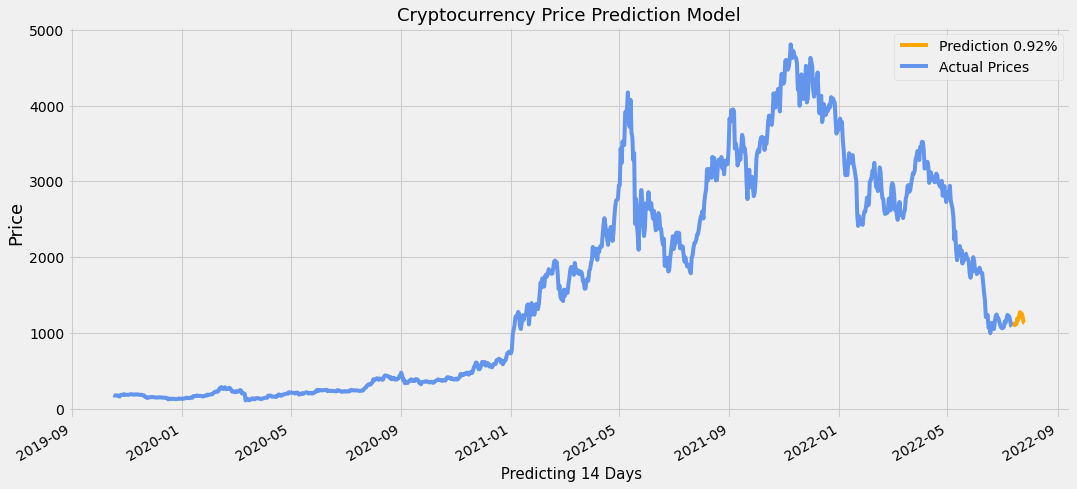

In [874]:
import matplotlib.dates as mdates

plt.figure(figsize=(16,8))

plt.plot(forecast_df.forecast, color='orange', label = f'Prediction {score_acc}%')
plt.plot(crypto_df.close, color='cornflowerblue', label = 'Actual Prices')
plt.title(f'Cryptocurrency Price Prediction Model', fontsize=18)
plt.xlabel(f' Predicting {forecast_days} Days', fontsize=15)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='upper right')
plt.gcf().autofmt_xdate()

plt.show()